# Chapter 2 Denoising and Detoning

reduce the noise and enhance the signal included in an empirical covariance matrix.

In [1]:
import numpy as np,pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## The Marcenko-Pastur Theorem


### SNIPPET 2.1

In [2]:

#--------------------------------------------------- 

def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N 
    # when var= 1, C = T^-1 X'X  is the correlation matrix associated with X
    # lambda+ =,lambda- = eMax, eMin
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2 
    eVal=np.linspace(eMin,eMax,pts) 
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 
    #pdf = pdf.ravel()
    pdf=pd.Series(pdf,index=eVal)
    return pdf


### SNIPPET 2.2

In [3]:
from sklearn.neighbors.kde import KernelDensity
#--------------------------------------------------- 
def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix 
    eVal,eVec=np.linalg.eigh(matrix) 
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc 
    eVal,eVec=eVal[indices],eVec[:,indices] 
    eVal=np.diagflat(eVal)
    return eVal,eVec 
#--------------------------------------------------- 
def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated 
    if len(obs.shape)==1:
        obs=obs.reshape(-1,1) 
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs) 
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:
        x=x.reshape(-1,1) 
    logProb=kde.score_samples(x) # log(density) 
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf


/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Text(0.5, 0, '$\\lambda$')

Text(0, 0.5, 'prob[$\\lambda$]')

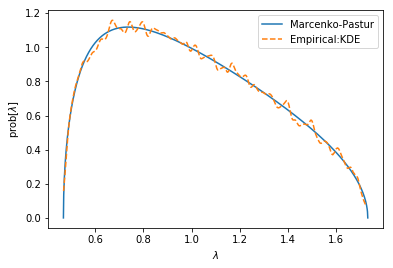

In [4]:
#--------------------------------------------------- 
x=np.random.normal(size=(10000,1000)) 
eVal0,eVec0=getPCA(np.corrcoef(x,rowvar=False)) # each column is a variable
pdf0=mpPDF(1.,q=x.shape[0]/float(x.shape[1]),pts=1000) 
pdf1=fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf
ax = plt.figure().add_subplot(111)
ax.plot(pdf0,label= 'Marcenko-Pastur')
ax.plot(pdf1,linestyle = '--',label= 'Empirical:KDE')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'prob[$\lambda$]')
ax.legend()


## Random Matrix with Signal (not perfectly random)

In [5]:
#SNIPPET 2.3 ADD SIGNAL TO A RANDOM COVARIANCE MATRIX
def getRndCov(nCols,nFacts): 
    w=np.random.normal(size=(nCols,nFacts))
    cov=np.dot(w,w.T) # random cov matrix, however not full rank 
    cov+=np.diag(np.random.uniform(size=nCols)) # full rank cov 
    return cov
#--------------------------------------------------- 
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov)) 
    corr=cov/np.outer(std,std) 
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error 
    return corr
#--------------------------------------------------- 
alpha,nCols,nFact,q=.995,1000,100,10 
cov=np.cov(np.random.normal(size=(nCols*q,nCols)),rowvar=False) 
cov=alpha*cov+(1-alpha)*getRndCov(nCols,nFact) # noise+signal 
corr0=cov2corr(cov)
eVal0,eVec0=getPCA(corr0)

In [6]:
#SNIPPET 2.4 FITTING THE MARCENKO–PASTUR PDF 
from scipy.optimize import minimize
#--------------------------------------------------- 
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    var = var[0]
    pdf0=mpPDF(var,q,pts) # theoretical pdf 
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf 
    #import pdb; pdb.set_trace()
    sse=np.sum((pdf1-pdf0)**2)
    return sse
#--------------------------------------------------- 
def findMaxEval(eVal,q,bWidth):
# Find max random eVal by fitting Marcenko’s dist 
    out=minimize(lambda *x: errPDFs(*x),.5,args=(eVal,q,bWidth),bounds=((1E-5,1-1E-5),))
    if out['success']:
        var=out['x'][0] 
    else:
        var=1 
    eMax=var*(1+(1./q)**.5)**2
    return eMax,var
#--------------------------------------------------- 
eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth=.01) 
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

# nFacts0 gives the number of the eigenvalue is assumed to be important (cutoff level lambda+ adjusted for the presence of nonrandom eigenvectors)

<BarContainer object of 1000 artists>

Text(0.5, 0, '$\\lambda$')

Text(0, 0.5, 'prob[$\\lambda$]')

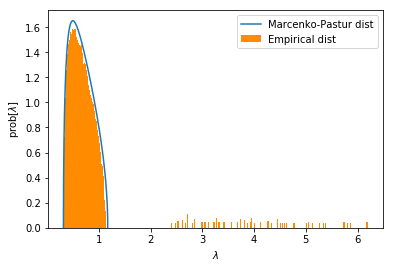

In [7]:
#---------------------------------------------------
# Fitting the Marcenko–Pastur PDF on a noisy covariance matrix.
# estimate the sigma for Marcenko-Pastur dist
bWidth=0.01
out=minimize(lambda *x: errPDFs(*x),.5,args=(np.diag(eVal0),q,bWidth),bounds=((1E-5,1-1E-5),))
if out['success']:
    var=out['x'][0] 
else:
    var=1

pdf0=mpPDF(var,q,pts=1000) # Marcenko-Pastur dist
pdf1=fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf
ax = plt.figure().add_subplot(111)
ax.plot(pdf0,label= 'Marcenko-Pastur dist')
ax.bar(pdf1.index,pdf1.values,width = bWidth,label= 'Empirical dist',color = 'darkorange')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'prob[$\lambda$]')
ax.legend()

## 2.5 Denoising

### 2.5.1 Constant Residual Eigenvalue Method

setting a constant eigenvalue for all random eigenvectors.

In [8]:
def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues 
    eVal_=np.diag(eVal).copy() 
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts) # average the rest
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T) 
    corr1=cov2corr(corr1)
    return corr1
#--------------------------------------------------- 
corr1=denoisedCorr(eVal0,eVec0,nFacts0) 
eVal1,eVec1=getPCA(corr1)

Text(0.5, 0, 'Eigenvalue number')

Text(0, 0.5, 'Eigenvalue (log-scale)')

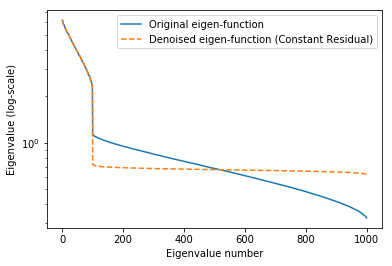

In [9]:
# A comparison of eigenvalues before and after applying the residual eigenvalue method.
ax = plt.figure().add_subplot(111)
ax.plot(np.diagonal(eVal0),label = 'Original eigen-function')
ax.plot(np.diagonal(eVal1),label = 'Denoised eigen-function (Constant Residual)',linestyle = '--')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number')
ax.set_ylabel('Eigenvalue (log-scale)')

### 2.5.2 Targeted Shrinkage
$\alpha$ regulates the amount fo shrinkage among the eigen vectors

In [10]:
#SNIPPET 2.6 DENOISING BY TARGETED SHRINKAGE
def denoisedCorr2(eVal,eVec,nFacts,alpha=0):
# Remove noise from corr through targeted shrinkage
    eValL,eVecL=eVal[:nFacts,:nFacts],eVec[:,:nFacts] 
    eValR,eVecR=eVal[nFacts:,nFacts:],eVec[:,nFacts:] 
    corr0=np.dot(eVecL,eValL).dot(eVecL.T) 
    corr1=np.dot(eVecR,eValR).dot(eVecR.T) 
    corr2=corr0+alpha*corr1+(1-alpha)*np.diag(np.diag(corr1)) 
    return corr2
#--------------------------------------------------- 
corr1=denoisedCorr2(eVal0,eVec0,nFacts0,alpha=.5) 
eVal1,eVec1=getPCA(corr1)

Text(0.5, 0, 'Eigenvalue number')

Text(0, 0.5, 'Eigenvalue (log-scale)')

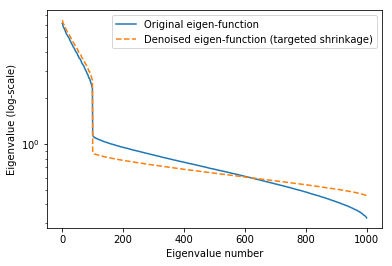

In [11]:
# A comparison of eigenvalues before and after applying the residual eigenvalue method.
ax = plt.figure().add_subplot(111)
ax.plot(np.diagonal(eVal0),label = 'Original eigen-function')
ax.plot(np.diagonal(eVal1),label = 'Denoised eigen-function (targeted shrinkage)',linestyle = '--')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number')
ax.set_ylabel('Eigenvalue (log-scale)')

# Experimental Results
## 2.7.1 Minimum Variance Portfolio

In [12]:
def corr2cov(corr,std):
    # Derive the covariance matrix from a correlation matrix
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error 
    cov = np.outer(std,std)*corr
    return cov

In [13]:

#SNIPPET 2.7 GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS
def formBlockMatrix(nBlocks,bSize,bCorr): 
    block=np.ones((bSize,bSize))*bCorr 
    block[range(bSize),range(bSize)]=1 
    corr=block_diag(*([block]*nBlocks)) 
    return corr
#--------------------------------------------------- 
def formTrueMatrix(nBlocks,bSize,bCorr):
    #In each block, the variances are drawn from a uniform distribution bounded between 5% and 20%; the vector of means is drawn from a Normal distribution with mean and standard deviation equal to the standard deviation from the covariance matrix
    corr0=formBlockMatrix(nBlocks,bSize,bCorr) 
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols) 
    corr0=corr0[cols].loc[cols].copy(deep=True) 
    std0=np.random.uniform(.05,.2,corr0.shape[0]) 
    cov0=corr2cov(corr0,std0) 
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1) 
    return mu0,cov0
#--------------------------------------------------- 
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf 
nBlocks,bSize,bCorr=10,50,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

In [14]:
#SNIPPET 2.8 GENERATING THE EMPIRICAL COVARIANCE MATRIX
def simCovMu(mu0,cov0,nObs,shrink=False): 
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs) 
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:
        cov1=LedoitWolf().fit(x).covariance_ 
    else:
        cov1=np.cov(x,rowvar=0)
    return mu1,cov1

In [15]:
# SNIPPET 2.9 DENOISING OF THE EMPIRICAL COVARIANCE MATRIX
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0) 
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth) 
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0) 
    corr1=denoisedCorr(eVal0,eVec0,nFacts0) 
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

In [16]:
#SNIPPET 2.10 DENOISING OF THE EMPIRICAL COVARIANCE MATRIX
def optPort(cov,mu=None): # optimal portfolio for minimum variance
    inv=np.linalg.inv(cov) 
    ones=np.ones(shape=(inv.shape[0],1)) 
    if mu is None:
        mu=ones
    w=np.dot(inv,mu) 
    w/=np.dot(ones.T,w) 
    return w
#--------------------------------------------------- 
nObs,nTrials,bWidth,shrink,minVarPortf=1000,100,.01,False,True 
w1= w1_s=pd.DataFrame(columns=range(cov0.shape[0]),
index=range(nTrials),dtype=float) 
w1_d=w1.copy(deep=True)
w1_s_d = w1_s.copy(deep = True)
np.random.seed(0)
for i in tqdm(range(nTrials)):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=True)
    if minVarPortf:
        mu1=None 
    cov1_d=deNoiseCov(cov1,nObs*1./cov1.shape[1],bWidth) 
    w1_s.loc[i]=optPort(cov1,mu1).flatten() 
    w1_s_d.loc[i]=optPort(cov1_d,mu1).flatten()
    
    
for i in tqdm(range(nTrials)):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=False)
    if minVarPortf:
        mu1=None 
    cov1_d=deNoiseCov(cov1,nObs*1./cov1.shape[1],bWidth) 
    w1.loc[i]=optPort(cov1,mu1).flatten() 
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()

In [18]:
#SNIPPET 2.11 ROOT-MEAN-SQUARE ERRORS
w0=optPort(cov0,None if minVarPortf else mu0) 
w0=np.repeat(w0.T,w1.shape[0],axis=0) 
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE  not shrunk not denoised
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE not shrunk denoised
rmsd_s=np.mean((w1_s-w0).values.flatten()**2)**.5 # RMSE shrunk not denoised
rmsd_s_d=np.mean((w1_s_d-w0).values.flatten()**2)**.5 # RMSE shrunk denoised

res_tab = pd.DataFrame(columns = ['Note denoised','Denoised'],index = ['Not shrunk','Shrunk'],data = np.array([[rmsd,rmsd_d],[rmsd_s,rmsd_s_d]]))
res_tab

,Note denoised,Denoised
Not shrunk,0.004929,0.001138
Shrunk,0.004929,0.001369


# Exercise

In [19]:
# 2.9 Exercise 
# Download the historical SP500 stocks daily closing price for the most recent year
import bs4 as bs
import requests
import yfinance as yf
import datetime

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
popular_tickers = ['AAPL','AMZN','FB','GOOGL','SPY']
data = yf.download(tickers, period = "ytd",auto_adjust = True,threads=True)
data = data.T.reset_index()

[**********************47%                       ]  235 of 505 downloaded

Exception in thread Thread-240:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/anaconda3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/site-packages/multitasking/__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)
  File "/anaconda3/lib/python3.7/site-packages/yfinance/__init__.py", line 537, in _download_one_threaded
    period, interval, prepost, proxy, rounding)
  File "/anaconda3/lib/python3.7/site-packages/yfinance/__init__.py", line 550, in _download_one
    proxy=proxy, rounding=rounding)
  File "/anaconda3/lib/python3.7/site-packages/yfinance/__init__.py", line 354, in history
    raise ValueError(self.ticker, err_msg)
ValueError: ('BRK.B', 'No data found, symbol may be delisted')



[**********************73%**********             ]  369 of 505 downloaded

Exception in thread Thread-375:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 57, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/anaconda3/lib/python3.7/socket.py", line 748, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "/anaconda3/lib/pyth

[**********************99%***********************]  499 of 505 downloaded

Exception in thread Thread-505:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/yfinance/__init__.py", line 363, in history
    quotes = self._parse_quotes(data["chart"]["result"][0])
  File "/anaconda3/lib/python3.7/site-packages/yfinance/__init__.py", line 208, in _parse_quotes
    timestamps = data["timestamp"]
KeyError: 'timestamp'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/anaconda3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/site-packages/multitasking/__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)
  File "/anaconda3/lib/python3.7/site-packages/yfinance/__init__.py", line 537, in _download_one_threaded
    period, interval, prepost, proxy, rounding)
  File "/anaconda3/lib/python

[**********************99%***********************]  501 of 505 downloaded

KeyboardInterrupt: 

In [104]:
# get the log return time series and calculate the covariance matrix for the SP 500 stocks
cls= data[data.level_0=='Close']
cls = cls.drop(['level_0'],axis = 'columns')

cls = cls.set_index(['level_1'])
cls = cls.T
cls.index = pd.to_datetime(cls.index)

logret = cls.apply(np.log,axis = 0).diff().drop(pd.to_datetime(['2020-01-02']),axis = 0).fillna(0)


In [105]:
# 2.a Covaraince matrix ; condition number of the correlation matrix

covmat = np.cov(logret,rowvar = False) # compute the covariance matrix
Codnum = np.linalg.cond(covmat) # condition number of correlation matrix
Codnum

55.04938510543094

In [85]:
# 2.b one hundread efficient frontiers

def portfolio_annualised_performance(weights, day_returns, cov_matrix):
    returns = np.sum(day_returns.T.dot(weights)) *252
    std = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, day_returns, cov_matrix):
    '''
    Return performance of required number of random portfolios
    '''
    results = np.zeros((2,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        mu, sigma = 0.1, 0.1 # mean and standard deviation of the alternative vectors of expected returns
        weights = np.random.normal(mu, sigma, len(day_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, day_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
    return results, weights_record


In [86]:
# Way 1 to get the efficient frontier: using optimization techniques to solve the efficient frontier 
# Time consuming
import scipy.optimize as opt



def efficient_return(day_returns, cov_matrix, target): # target is the target value for returning the efficient frontier axis (similiar to a y-axis value )
    num_assets = len(day_returns)
    args = (day_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, day_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = opt.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(day_returns, cov_matrix, returns_range): # return efficient frontier
    efficients = []
    for ret in tqdm(returns_range,desc='calculating efficient frontier using optimization method:'):
        efficients.append(efficient_return(day_returns, cov_matrix, ret))
    return efficients

In [87]:
def ef_with_random_portfolio_opt(day_returns,cov_matrix,num_portfolios,ax = None,return_plot = True):
    results, weights = random_portfolios(num_portfolios,day_returns, cov_matrix)
        
    target = np.linspace(max(np.min(results[1]),0), np.quantile(results[1],0.7), 30)
    efficient_portfolios = efficient_frontier(day_returns, cov_matrix, target)
    frontier = [p['fun'] for p in efficient_portfolios]
    
    if return_plot:
        if not ax:
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111)
            
            #ax.legend(labelspacing=0.8)
        ax.plot(frontier, target,color = 'black',linewidth = 2,label = 'efficient frontier')
        
        ax.scatter(results[0,:],results[1,:], marker='o', s=10, alpha=0.3)
        ax.set_title('Calculated Portfolio Optimization based on Efficient Frontier')
        ax.set_xlabel('annualised volatility')
        ax.set_ylabel('annualised returns')
        ax.legend()
    
    return ax,[frontier,target]
    

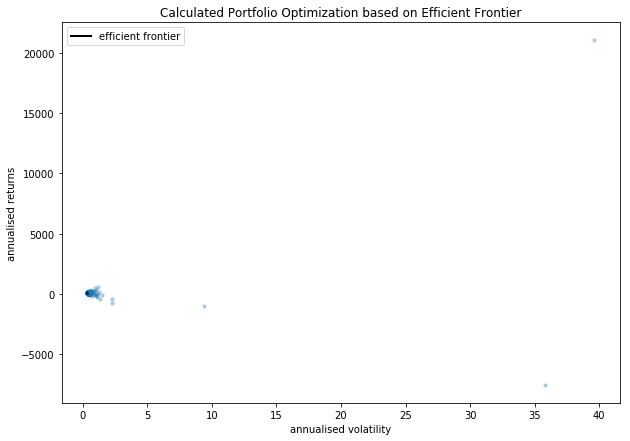

In [88]:

target_ret = pd.DataFrame(logret.T) # select 50 stocks to construct portfolio
target_cov = np.cov(target_ret)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax,frontier_ret = ef_with_random_portfolio_opt(target_ret,target_cov,1000,ax = ax)

In [89]:
# Way 2: monte-carlo method, direct infer from the efficient frontier from the simulated data



def efficient_return_simu(results, target):

    # return efficient frontier
    # use +-5% area of the target, return the nearest min 
    results = pd.DataFrame(results.T).sort_values(by = 1)
    closiest_idx = np.argmin(np.abs(results[1]-target))
    data_target = results[1][closiest_idx]
    target_range_min = min(data_target*0.95, data_target*1.05)
    target_range_max = max(data_target*0.95, data_target*1.05)
    sub_results = results.loc[(results[1] <= target_range_max) & (results[1] >= target_range_min),0:2]

    return min(sub_results[0])


def efficient_frontier_emp(day_returns, cov_matrix, num_portfolios,  returns_range, random_seed=0):
    efficients = []
    np.random.seed(random_seed)
    results, weights = random_portfolios(
        num_portfolios, day_returns, cov_matrix)
    for ret in returns_range:
        efficients.append(efficient_return_simu(results, ret))
    return efficients

In [90]:
def ef_with_random_portfolio_simu(day_returns, cov_matrix, num_portfolios, ax=None, return_plot=True, random_seed=0,mean_frontier = None):
    results, weights = random_portfolios(
        num_portfolios, day_returns, cov_matrix)
    
    #target_start = max(results[1][results[0]==np.min(results[0])][0],0)
    target_start = 0
    if True: #not return_plot:
        target_end = 400
    else:
        target_end = results[1][results[0]==np.max(results[0])][0]
    
    target = np.linspace(target_start, target_end, 30)
    efficient_portfolios = None
    efficient_portfolios = efficient_frontier_emp(day_returns, cov_matrix, num_portfolios, target, random_seed=random_seed)

    if return_plot:
        if not ax:
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111)

            # ax.legend(labelspacing=0.8)
        if mean_frontier:
            ax.plot(mean_frontier[0], mean_frontier[1], color='black',linewidth=2, label='mean efficient frontier')
        else:
            ax.plot(efficient_portfolios, target, color='black',linewidth=2, label='efficient frontier')

        ax.scatter(results[0, :], results[1, :], marker='o', s=10, alpha=0.3)
        ax.set_title(
            'Calculated Portfolio Optimization based on Efficient Frontier')
        ax.set_xlabel('annualised volatility')
        ax.set_ylabel('annualised returns')
        ax.legend()
    else:
        ax = None

    return ax, [efficient_portfolios, target]

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


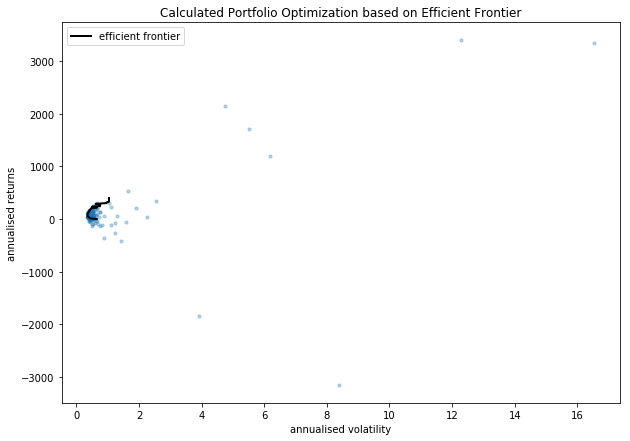

In [91]:
np.random.seed(3)
target_ret = pd.DataFrame(logret.T)
target_cov = np.cov(target_ret)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax,frontier_ret = ef_with_random_portfolio_simu(target_ret,target_cov,1000,ax = ax)

In [92]:
def MC_ef_frontier(day_returns,cov_matrix,itertimes = 100,random_seed = 3):
    np.random.seed(random_seed)
    target_ret = pd.DataFrame(day_returns.T)
    target_cov = cov_matrix
    frontier = []
    for i in tqdm(range(itertimes)):
        ax,frontier_ret = ef_with_random_portfolio_simu(target_ret,target_cov,1000,return_plot = False,random_seed = i)
        frontier.append(frontier_ret[0])
    mean_frontier_vol = np.mean(frontier,axis = 0)
    mean_frontier_ret = frontier_ret[1]

In [93]:
MC_ef_frontier(logret,covmat,itertimes = 100,random_seed = 3)

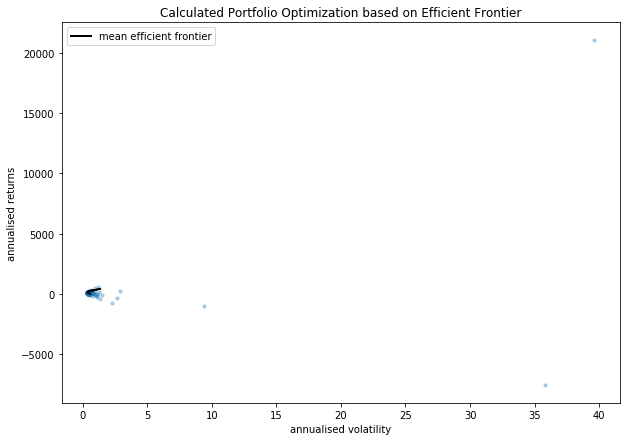

In [95]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax,_ = ef_with_random_portfolio_simu(target_ret,target_cov,1000, ax=ax, return_plot=True, random_seed=0,mean_frontier = [mean_frontier,frontier_ret[1]])

In [96]:
# variance of the errors against the mean efficient frontier
def error_mean_ef_frontier(frontiers, mean_frontier):
    err = []
    for frontier in frontiers:
        err.append(np.std(frontier-mean_frontier))
    return np.var(err)

In [97]:
error_mean_ef_frontier(frontier_ret, mean_frontier)

3542.1298030633243

<BarContainer object of 5 artists>

Text(0.5, 0, '$\\lambda$')

Text(0, 0.5, 'prob[$\\lambda$]')

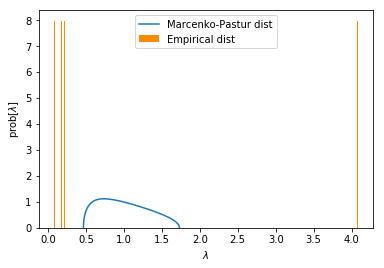

In [98]:
# exercise 3
corr3=cov2corr(covmat)
eVal3,eVec3=getPCA(corr3)
# Fitting the Marcenko–Pastur PDF on a noisy covariance matrix.
# estimate the sigma for Marcenko-Pastur dist
bWidth=0.01
out=minimize(lambda *x: errPDFs(*x),.5,args=(np.diag(eVal3),q,bWidth),bounds=((1E-5,1-1E-5),))
if out['success']:
    var=out['x'][0] 
else:
    var=1
print('-'*10)
print(r'value of $\sigma^2$ implied by Marcenko-Pastur distribution: ' )
pdf0=mpPDF(var,q,pts=1000) # Marcenko-Pastur dist
pdf3=fitKDE(np.diag(eVal3),bWidth=.01) # empirical pdf
ax = plt.figure().add_subplot(111)
ax.plot(pdf0,label= 'Marcenko-Pastur dist')
ax.bar(pdf3.index,pdf3.values,width = bWidth,label= 'Empirical dist',color = 'darkorange')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'prob[$\lambda$]')
ax.legend()